In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

C:\Users\Magda\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Magda\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Magda\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Magda\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passi

In [2]:
df = pd.read_csv('../agent/cleaned_data/VET.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1/2/2013,52.950001,53.270000,52.849998,53.009998,28.775816,8400
1,1/3/2013,52.650002,52.650002,52.230000,52.590000,28.547823,4600
2,1/4/2013,52.740002,52.740002,52.360001,52.650002,28.580389,4700
3,1/7/2013,52.560001,52.650002,52.520000,52.650002,28.580389,4700
4,1/8/2013,52.700001,53.119999,52.480000,52.820000,28.672672,2900


In [3]:
class Agent:

    LEARNING_RATE = 1e-4
    LAYER_SIZE = 256
    GAMMA = 0.9
    OUTPUT_SIZE = 3

    def __init__(self, state_size, window_size, trend, skip):
        self.state_size = state_size
        self.window_size = window_size
        self.half_window = window_size // 2
        self.trend = trend
        self.skip = skip
        self.X = tf.placeholder(tf.float32, (None, self.state_size))
        self.REWARDS = tf.placeholder(tf.float32, (None))
        self.ACTIONS = tf.placeholder(tf.int32, (None))
        feed_forward = tf.layers.dense(self.X, self.LAYER_SIZE, activation = tf.nn.relu)
        self.logits = tf.layers.dense(feed_forward, self.OUTPUT_SIZE, activation = tf.nn.softmax)
        input_y = tf.one_hot(self.ACTIONS, self.OUTPUT_SIZE)
        loglike = tf.log((input_y * (input_y - self.logits) + (1 - input_y) * (input_y + self.logits)) + 1)
        rewards = tf.tile(tf.reshape(self.REWARDS, (-1,1)), [1, self.OUTPUT_SIZE])
        self.cost = -tf.reduce_mean(loglike * (rewards + 1)) 
        self.optimizer = tf.train.AdamOptimizer(learning_rate = self.LEARNING_RATE).minimize(self.cost)
        self.sess = tf.InteractiveSession()
        self.sess.run(tf.global_variables_initializer())
    
    def predict(self, inputs):
        return self.sess.run(self.logits, feed_dict={self.X:inputs})
    
    def get_state(self, t):
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d : t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        return np.array([res])
    
    def discount_rewards(self, r):
        discounted_r = np.zeros_like(r)
        running_add = 0
        for t in reversed(range(0, r.size)):
            running_add = running_add * self.GAMMA + r[t]
            discounted_r[t] = running_add
        return discounted_r
    
    def get_predicted_action(self, sequence):
        prediction = self.predict(np.array(sequence))[0]
        return np.argmax(prediction)
    
    def buy(self, initial_money):
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        state = self.get_state(0)
        for t in range(0, len(self.trend) - 1, self.skip):
            action = self.get_predicted_action(state)
            next_state = self.get_state(t + 1)
            
            if action == 1 and initial_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                inventory.append(self.trend[t])
                initial_money -= self.trend[t]
                states_buy.append(t)
                print('day %d: buy 1 unit at price %f, total balance %f'% (t, self.trend[t], initial_money))
                
                
            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                initial_money += self.trend[t]
                states_sell.append(t)
                try:
                    invest = ((close[t] - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell 1 unit at price %f, investment %f %%, total balance %f,'
                    % (t, close[t], invest, initial_money)
                )
            
            state = next_state
        invest = ((initial_money - starting_money) / starting_money) * 100
        total_gains = initial_money - starting_money
        return states_buy, states_sell, total_gains, invest
        
    
    def train(self, iterations, checkpoint, initial_money):
        for i in range(iterations):
            ep_history = []
            total_profit = 0
            inventory = []
            state = self.get_state(0)
            starting_money = initial_money
            for t in range(0, len(self.trend) - 1, self.skip):
                action = self.get_predicted_action(state)
                next_state = self.get_state(t + 1)
                if action == 1 and starting_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                    inventory.append(self.trend[t])
                    starting_money -= close[t]
                
                elif action == 2 and len(inventory):
                    bought_price = inventory.pop(0)
                    total_profit += self.trend[t] - bought_price
                    starting_money += self.trend[t]
                ep_history.append([state,action,starting_money,next_state])
                state = next_state
            ep_history = np.array(ep_history)
            ep_history[:,2] = self.discount_rewards(ep_history[:,2])
            cost, _ = self.sess.run([self.cost, self.optimizer], feed_dict={self.X:np.vstack(ep_history[:,0]),
                                                    self.REWARDS:ep_history[:,2],
                                                    self.ACTIONS:ep_history[:,1]})
            if (i+1) % checkpoint == 0:
                print('epoch: %d, total rewards: %f.3, cost: %f, total money: %f'%(i + 1, total_profit, cost,
                                                                                  starting_money))

In [4]:
close = df.Close.values.tolist()
initial_money = 10000
window_size = 30
skip = 1
agent = Agent(state_size = window_size,
             window_size = window_size,
             trend = close,
             skip = skip)
agent.train(iterations = 200, checkpoint = 10, initial_money = initial_money)

Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


C:\Users\Magda\anaconda3\lib\site-packages\ipykernel_launcher.py:107: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


epoch: 10, total rewards: -22.600028.3, cost: -31021.298828, total money: 9977.399972
epoch: 20, total rewards: -39.280034.3, cost: -31680.781250, total money: 9960.719966
epoch: 30, total rewards: -18.580036.3, cost: -32232.970703, total money: 9981.419964
epoch: 40, total rewards: -61.529998.3, cost: -32554.531250, total money: 9938.470002
epoch: 50, total rewards: -61.969984.3, cost: -32775.023438, total money: 9835.750015
epoch: 60, total rewards: -36.090011.3, cost: -32967.480469, total money: 9935.469990
epoch: 70, total rewards: -50.080003.3, cost: -32990.710938, total money: 9862.449997
epoch: 80, total rewards: -192.720002.3, cost: -32572.167969, total money: 9615.689998
epoch: 90, total rewards: -716.669986.3, cost: -31489.859375, total money: 8840.420014
epoch: 100, total rewards: -819.669990.3, cost: -31348.394531, total money: 8687.160011
epoch: 110, total rewards: -708.249990.3, cost: -31923.080078, total money: 8729.500012
epoch: 120, total rewards: -653.269977.3, cost: 

In [5]:
states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 9: buy 1 unit at price 53.049999, total balance 9946.950001
day 10: buy 1 unit at price 51.439999, total balance 9895.510002
day 11: buy 1 unit at price 51.560001, total balance 9843.950001
day 12: buy 1 unit at price 51.500000, total balance 9792.450001
day 13: buy 1 unit at price 51.270000, total balance 9741.180000
day 14, sell 1 unit at price 51.619999, investment -2.695571 %, total balance 9792.799999,
day 16: buy 1 unit at price 50.580002, total balance 9742.219997
day 17: buy 1 unit at price 51.480000, total balance 9690.739998
day 18: buy 1 unit at price 51.020000, total balance 9639.719997
day 19: buy 1 unit at price 51.310001, total balance 9588.409996
day 20: buy 1 unit at price 51.869999, total balance 9536.539997
day 22, sell 1 unit at price 50.990002, investment -0.874800 %, total balance 9587.529999,
day 23, sell 1 unit at price 51.209999, investment -0.678825 %, total balance 9638.739998,
day 24, sell 1 unit at price 51.099998, investment -0.776702 %, total balance 

day 170, sell 1 unit at price 54.740002, investment -1.316026 %, total balance 9498.919994,
day 171: buy 1 unit at price 54.740002, total balance 9444.179993
day 172: buy 1 unit at price 54.970001, total balance 9389.209991
day 173, sell 1 unit at price 54.939999, investment -0.615051 %, total balance 9444.149990,
day 175, sell 1 unit at price 55.250000, investment 0.036213 %, total balance 9499.399990,
day 176, sell 1 unit at price 54.910000, investment 1.179288 %, total balance 9554.309990,
day 179, sell 1 unit at price 55.869999, investment 1.379057 %, total balance 9610.179989,
day 180, sell 1 unit at price 55.669998, investment 2.844997 %, total balance 9665.849987,
day 181, sell 1 unit at price 55.770000, investment 4.145661 %, total balance 9721.619987,
day 183: buy 1 unit at price 55.139999, total balance 9666.479988
day 186, sell 1 unit at price 55.099998, investment 3.610376 %, total balance 9721.579987,
day 189, sell 1 unit at price 56.279999, investment 5.968741 %, total ba

day 350: buy 1 unit at price 66.970001, total balance 8840.199970
day 352, sell 1 unit at price 67.250000, investment 16.228827 %, total balance 8907.449970,
day 354: buy 1 unit at price 67.169998, total balance 8840.279972
day 356, sell 1 unit at price 68.809998, investment 20.486774 %, total balance 8909.089970,
day 357: buy 1 unit at price 68.669998, total balance 8840.419971
day 359: buy 1 unit at price 68.599998, total balance 8771.819973
day 361: buy 1 unit at price 68.489998, total balance 8703.329975
day 362: buy 1 unit at price 68.660004, total balance 8634.669971
day 363: buy 1 unit at price 69.300003, total balance 8565.369968
day 364, sell 1 unit at price 69.680000, investment 17.385444 %, total balance 8635.049969,
day 365, sell 1 unit at price 70.180000, investment 12.431917 %, total balance 8705.229969,
day 366, sell 1 unit at price 69.610001, investment 10.738148 %, total balance 8774.839970,
day 369: buy 1 unit at price 71.779999, total balance 8703.059971
day 370: buy

day 513: buy 1 unit at price 40.889999, total balance 8971.789978
day 514: buy 1 unit at price 43.650002, total balance 8928.139977
day 515: buy 1 unit at price 43.310001, total balance 8884.829975
day 516: buy 1 unit at price 43.849998, total balance 8840.979977
day 517, sell 1 unit at price 43.320000, investment -22.435092 %, total balance 8884.299976,
day 518: buy 1 unit at price 44.110001, total balance 8840.189976
day 519, sell 1 unit at price 44.430000, investment -21.943075 %, total balance 8884.619976,
day 521, sell 1 unit at price 42.419998, investment -22.093668 %, total balance 8927.039974,
day 522: buy 1 unit at price 42.259998, total balance 8884.779976
day 524, sell 1 unit at price 45.599998, investment -12.660411 %, total balance 8930.379974,
day 525, sell 1 unit at price 49.189999, investment 8.707179 %, total balance 8979.569973,
day 527, sell 1 unit at price 45.549999, investment 2.590085 %, total balance 9025.119972,
day 528: buy 1 unit at price 45.669998, total bala

day 688: buy 1 unit at price 31.570000, total balance 9237.719975
day 689: buy 1 unit at price 30.950001, total balance 9206.769974
day 691: buy 1 unit at price 32.150002, total balance 9174.619972
day 692, sell 1 unit at price 31.670000, investment -0.314764 %, total balance 9206.289972,
day 693: buy 1 unit at price 32.619999, total balance 9173.669973
day 694: buy 1 unit at price 34.180000, total balance 9139.489973
day 695: buy 1 unit at price 36.220001, total balance 9103.269972
day 696, sell 1 unit at price 37.189999, investment 9.029604 %, total balance 9140.459971,
day 698: buy 1 unit at price 37.849998, total balance 9102.609972
day 701, sell 1 unit at price 37.400002, investment 8.030048 %, total balance 9140.009974,
day 702, sell 1 unit at price 37.639999, investment 15.779764 %, total balance 9177.649973,
day 706: buy 1 unit at price 35.299999, total balance 9142.349974
day 709, sell 1 unit at price 34.480000, investment 5.864292 %, total balance 9176.829973,
day 710: buy 1 

day 860: buy 1 unit at price 33.160000, total balance 9230.259983
day 861: buy 1 unit at price 33.709999, total balance 9196.549984
day 862, sell 1 unit at price 34.680000, investment 18.685835 %, total balance 9231.229984,
day 864, sell 1 unit at price 35.939999, investment 26.996465 %, total balance 9267.169983,
day 865: buy 1 unit at price 35.009998, total balance 9232.159985
day 866, sell 1 unit at price 33.590000, investment 24.499632 %, total balance 9265.749985,
day 867: buy 1 unit at price 33.619999, total balance 9232.129986
day 869, sell 1 unit at price 32.799999, investment 18.883650 %, total balance 9264.929985,
day 871: buy 1 unit at price 32.820000, total balance 9232.109985
day 873: buy 1 unit at price 33.560001, total balance 9198.549984
day 874: buy 1 unit at price 32.549999, total balance 9165.999985
day 876, sell 1 unit at price 31.280001, investment 11.198015 %, total balance 9197.279986,
day 878, sell 1 unit at price 30.690001, investment -6.060599 %, total balance

day 1027: buy 1 unit at price 41.189999, total balance 9227.389990
day 1028: buy 1 unit at price 41.240002, total balance 9186.149988
day 1030: buy 1 unit at price 40.970001, total balance 9145.179987
day 1031, sell 1 unit at price 39.959999, investment -7.905048 %, total balance 9185.139986,
day 1033: buy 1 unit at price 39.720001, total balance 9145.419985
day 1035: buy 1 unit at price 40.660000, total balance 9104.759985
day 1037: buy 1 unit at price 40.430000, total balance 9064.329985
day 1039, sell 1 unit at price 39.700001, investment -8.419834 %, total balance 9104.029986,
day 1041: buy 1 unit at price 40.450001, total balance 9063.579985
day 1044: buy 1 unit at price 39.340000, total balance 9024.239985
day 1045, sell 1 unit at price 39.119999, investment -9.882518 %, total balance 9063.359984,
day 1048: buy 1 unit at price 38.770000, total balance 9024.589983
day 1049: buy 1 unit at price 38.570000, total balance 8986.019983
day 1051: buy 1 unit at price 38.810001, total bala

day 1196: buy 1 unit at price 35.340000, total balance 9002.309979
day 1197: buy 1 unit at price 35.189999, total balance 8967.119980
day 1198: buy 1 unit at price 35.040001, total balance 8932.079979
day 1200, sell 1 unit at price 34.439999, investment 10.561795 %, total balance 8966.519978,
day 1201, sell 1 unit at price 34.590000, investment 8.979207 %, total balance 9001.109978,
day 1202, sell 1 unit at price 34.360001, investment 5.108602 %, total balance 9035.469978,
day 1204: buy 1 unit at price 33.869999, total balance 9001.599980
day 1205: buy 1 unit at price 34.119999, total balance 8967.479981
day 1206: buy 1 unit at price 34.509998, total balance 8932.969982
day 1207: buy 1 unit at price 34.849998, total balance 8898.119984
day 1209: buy 1 unit at price 34.630001, total balance 8863.489983
day 1211, sell 1 unit at price 33.610001, investment 4.346481 %, total balance 8897.099983,
day 1212, sell 1 unit at price 33.520000, investment 4.553958 %, total balance 8930.619984,
day

day 1375: buy 1 unit at price 33.810001, total balance 9020.759989
day 1376: buy 1 unit at price 34.430000, total balance 8986.329989
day 1378, sell 1 unit at price 35.009998, investment 0.143018 %, total balance 9021.339987,
day 1379, sell 1 unit at price 34.150002, investment 0.382131 %, total balance 9055.489988,
day 1380: buy 1 unit at price 35.169998, total balance 9020.319990
day 1383, sell 1 unit at price 36.009998, investment 0.194768 %, total balance 9056.329989,
day 1385: buy 1 unit at price 36.049999, total balance 9020.279989
day 1386, sell 1 unit at price 35.700001, investment -1.025780 %, total balance 9055.979990,
day 1388: buy 1 unit at price 36.580002, total balance 9019.399988
day 1391, sell 1 unit at price 37.160000, investment 11.625109 %, total balance 9056.559988,
day 1393: buy 1 unit at price 35.939999, total balance 9020.619989
day 1396: buy 1 unit at price 35.720001, total balance 8984.899988
day 1400: buy 1 unit at price 36.529999, total balance 8948.369989
da

day 1552: buy 1 unit at price 26.559999, total balance 8529.869986
day 1553: buy 1 unit at price 26.049999, total balance 8503.819986
day 1555: buy 1 unit at price 25.190001, total balance 8478.629986
day 1557, sell 1 unit at price 24.570000, investment -18.776861 %, total balance 8503.199986,
day 1560: buy 1 unit at price 24.900000, total balance 8478.299986
day 1561, sell 1 unit at price 25.459999, investment -18.135052 %, total balance 8503.759985,
day 1564: buy 1 unit at price 25.719999, total balance 8478.039986
day 1566, sell 1 unit at price 24.830000, investment -15.255971 %, total balance 8502.869986,
day 1567: buy 1 unit at price 25.150000, total balance 8477.719986
day 1569, sell 1 unit at price 24.629999, investment -12.035717 %, total balance 8502.349985,
day 1570, sell 1 unit at price 24.700001, investment -9.124354 %, total balance 8527.049986,
day 1571, sell 1 unit at price 25.070000, investment -2.108555 %, total balance 8552.119986,
day 1573: buy 1 unit at price 24.620

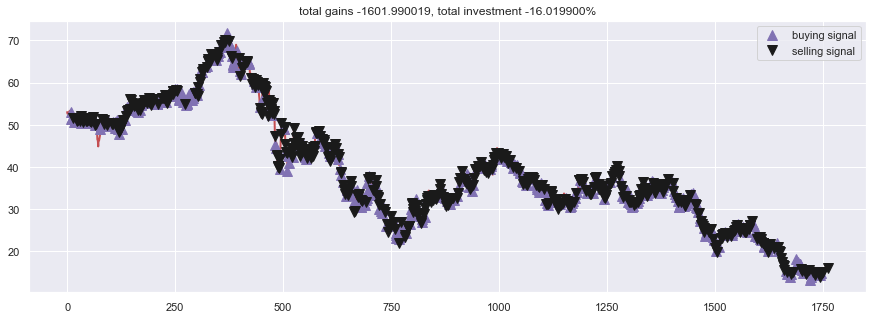

In [6]:
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.show()